# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic; #simulator kram

using Rotations; # used for initial position

#find packages on julia hub
using ReinforcementLearning; 
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save and load model

In [2]:
create_visualization(); #from flyonics package

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [4]:
#connect RL-library with simulation via this environment
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    #required
    action_space::A
    observation_space::Space{Vector{ClosedInterval{T}}}
    state::Vector{T} #state of system; goes in policy
    action::ACT #action that system does next
    done::Bool #e.g. drone crashed
    t::T
    rng::R

    name::String #for multible environoments
    visualization::Bool
    realtime::Bool # For humans recognizable visualization
    
    # Everything you need aditionaly can also go in here.
    #additional states for simulation; not for policy
    x_W::Vector{T}
    v_B::Vector{T}
    a_B::Vector{T}
    R_W::Matrix{T}
    ω_B::Vector{T}
    α_B::Vector{T}
    
    wind_W::Vector{T}
    
    Δt::T
end

In [5]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
     
    #continuous = true,
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    #action_space = Base.OneTo(21) # 21 discrete positions for the flaps
    
    #here: two actions; continuous
    #Beginning: stay 2D
    #Later: 4D: independent rotors and flaps (thats all actuators)
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # thrust in N
            -1.0..1.0, # flaps in rad
            ], 
    )

    #reduced to 2D for now
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # rotation arround y
            typemin(T)..typemax(T), # rotation velocity arround y
            typemin(T)..typemax(T), # Body velocity error along x
            typemin(T)..typemax(T), # Body velocity error along z
            ], 
    )
    
    if visualization
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,QuatRotation([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]));
        set_actuators(name, [0.0; 0.0; 0.0; 0.0])
    end

    #instantiates the sctruct from before
    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        rand(action_space),
        false, # episode done ?
        0.0, # time
        rng, # random number generator  
        name,
        visualization, # visualization
        realtime, # realtime visualization
        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        zeros(T, 3), # a_B
        Array{T}([1 0 0; 0 1 0; 0 0 1]),
        zeros(T, 3), # ω_B
        zeros(T, 3), # α_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt  
    )
    
    #do this for simulation start
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [6]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[5]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, a_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, α_B::Vector{T}, wind_W::Vector{T}, Δt::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[4]:4

# Define the RL interface

In [7]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [8]:
target_vel_W = [0.0; 0.0; 0.2]

3-element Vector{Float64}:
 0.0
 0.0
 0.2

In [9]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    #this rewards makes drone go straight up :)
    stay_alive = 100.0
    
    return stay_alive - abs(env.state[3])*100.0 - abs(env.state[4])*100.0
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [10]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    # Visualize initial state
    set_transform(env.name, env.x_W,QuatRotation(env.R_W));
    set_actuators(env.name, [0.0; 0.0; 0.0; 0.0])
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.a_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotY(-pi/2.0)*RotX(pi)));
    env.ω_B = [0.0; 0.0; 0.0];
    env.α_B = [0.0; 0.0; 0.0];
    
    
    env.wind_W = [0.0; 0.0; 0.0];
    
    target_vel_B = transpose(env.R_W)*target_vel_W
    vel_error = (env.v_B - target_vel_B)
 
    env.state = [Rotations.params(RotYXZ(env.R_W))[1]; env.ω_B[2];  vel_error[1]; vel_error[3]]

    env.t = 0.0
    env.action = [0.0]
    env.done = false
    nothing
end;

In [11]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
# Apply chosen actions on simulator
# add a third function to environment with action a
function (env::VtolEnv)(a)

    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[1], a[2], a[2]]
   
    _step!(env, next_action)
end

In [12]:
env = VtolEnv();

In [13]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[11]:5
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [14]:
# actual step for each simulation iteration
# Trajectory: generate externally; and then do some calculation in the step; in the environment add additional state: v_soll; v_ist --> use in reward function
# Generate trajectories randomly, so that iterations train on different trajectories
# Test set: always use same trajectory
# TODO maybe we can get trajectory generation from last year
# Evaluation metric: how well do I track my velocity trajectory? Look for 2-3 metrics here and thats ok
function _step!(env::VtolEnv, next_action)
        
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.a_B, env.R_W, env.ω_B, env.α_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)


    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end
    
    # Visualize the new state
    if env.visualization
        # TODO: Can be removed for real trainings
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
    end
 
    env.t += env.Δt
    
    # State space
    # Pass more states to RF-Learning-Agent, if required
    rot = Rotations.params(RotYXZ(env.R_W))[1]
    env.state[1] = rot # rotation arround y
    env.state[2] = env.ω_B[2] # rotation velocity arround y
    
    target_vel_B = transpose(env.R_W)*target_vel_W
    vel_error = (env.v_B - target_vel_B)
    env.state[3] = vel_error[1] # body velocity error along x
    env.state[4] = vel_error[3] # body velocity error along z 
    
    
    # Termination criteria
    env.done =
        #norm(v_B) > 2.0 || # stop if body is too fast
        env.x_W[3] < -1.0 || # stop if body is below -1m
        0.0 > rot || # Stop if the drone is pitched 90°.
        rot > pi || # Stop if the drone is pitched 90°.
        env.t > 10 # stop after 10s
    nothing #return nothing
end;

In [15]:
RLBase.test_runnable!(env)

random policy with VtolEnv: Error During Test at /home/leouscin/.julia/packages/ReinforcementLearningBase/E7jI5/src/base.jl:266
  Got exception outside of a @test
  BoundsError: attempt to access Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Float64} at index [6]
  Stacktrace:
    [1] indexed_iterate
      @ ./tuple.jl:88 [inlined]
    [2] _step!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Random._GLOBAL_RNG}, next_action::Vector{Float64})
      @ Main ./In[14]:14
    [3] (::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Random._GLOBAL_RNG})(a::Vector{Float64})
      @ Main ./In[11]:10
    [4] macro expansion
      @ ~/.julia/packages/ReinforcementLearningBase/E7jI5/src/base.jl:281 [inlined]
    [5] macro expansion
      @ /usr/share/julia/stdlib/v1.8/Test/src/Test.jl:1363 [inlined]
    [6] test_runnable!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, Random._GLOBAL

LoadError: [91mSome tests did not pass: 2 passed, 0 failed, 1 errored, 0 broken.[39m

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [16]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8 #number of envs
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ]);

In [17]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    #ActorCritic Policy
    approximator = ActorCritic(
                #ns - number states as input
                #3 layer; last layer splitted in mean and variance; then action is sampled
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),#
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [18]:
    #learning
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        # depends on RL-Algorithm
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );

┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


In [19]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models/", "vtol_ppo_$t.bson")
    @save f model
    println("parameters at step $t saved to $f")
end

saveModel (generic function with 1 method)

In [20]:
function loadModel()
    # TODO use correct relative path here
    f = joinpath("./RL_models/", "vtol_ppo_300000.bson")
    @load f model
    return model
end

loadModel (generic function with 1 method)

In [21]:
#use pretrained model
agent.policy.approximator = loadModel();

LoadError: SystemError: opening file "./RL_models/vtol_ppo_300000.bson": No such file or directory

In [22]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [23]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_000_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)
    ),
)

LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Float64} at index [6]
    Stacktrace:
     [1] [0m[1mindexed_iterate[22m
    [90m   @ [39m[90m./[39m[90m[4mtuple.jl:88[24m[39m[90m [inlined][39m
     [2] [0m[1m_step![22m[0m[1m([22m[90menv[39m::[0mVtolEnv[90m{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}[39m, [90mnext_action[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mIn[14]:14[24m[39m
     [3] [0m[1m(::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG})[22m[0m[1m([22m[90ma[39m::[0mSubArray[90m{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[39m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mIn[11]:10[24m[39m
     [4] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/.julia/packages/ReinforcementLearningZoo/tvfq9/src/algorithms/policy_gradient/[39m[90m[4mmulti_thread_env.jl:91[24m[39m[90m [inlined][39m
     [5] [0m[1m(::ReinforcementLearningZoo.var"#130#131"{MultiThreadEnv{VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, Matrix{Float64}, Vector{Float64}, Space{Matrix{ClosedInterval{Float64}}}, Space{Matrix{ClosedInterval{Float64}}}, Nothing}, Matrix{Float64}, Int64, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[36mReinforcementLearningZoo[39m [90m./[39m[90m[4mthreadingconstructs.jl:258[24m[39m

...and 7 more exceptions.


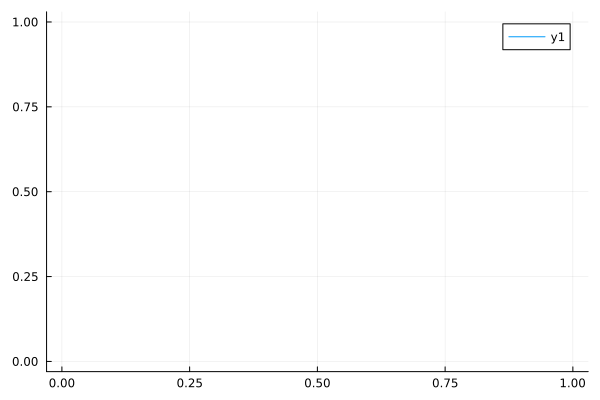

In [24]:
plot(episode_test_reward_hook.rewards)

In [25]:
close_visualization(); # closes the MeshCat visualization